<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb) | [Contents](Index.ipynb) | [Application: A Face Detection Pipeline](05.14-Image-Features.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: 核密度估計(Kernel Density Estimation)

GMM是介於集群評估器和密度評估器間的混合體，藉由展示把密度當作是高斯分布的加權總和來達成此點。

KDE在某種意義上是一種使用高斯混合想法的演算法，然後把此邏輯極端到:使用由*每一個資料點*的一個高斯元件的混合，產生出一個本質上是無母體的密度評估器結果。

核密度估計是用來估計未知的機率密度函數f

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## KDE的使用動機: 直方圖




In [2]:
# 從2個常態分布建立資料
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

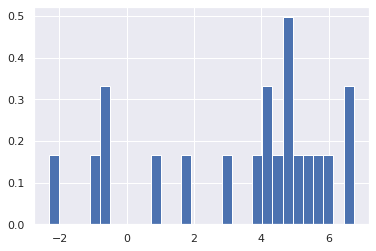

In [11]:
# y軸為正規化後反映機率的密度
hist = plt.hist(x, bins=30, density= True)

正規化只是簡單改變y軸的比例，讓相對的高度可以反映出和直接計算籃子中數目的直方圖。正規化後讓所有直方圖的面積為1。

In [12]:
# 確認直方圖面積是否為1
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0000000000000002

使用直方圖當作是密度評估器的其中一個問題是籃子大小以及位置的選擇，可以會導致表現出來的樣子在質方面不同的特徵。

例如:如果檢視此資料的其中一個只有20個資料點版本的情況，如何去畫出這些籃子的選擇，會導致出完全不一樣的資料意涵。考慮以下的例子:

In [7]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

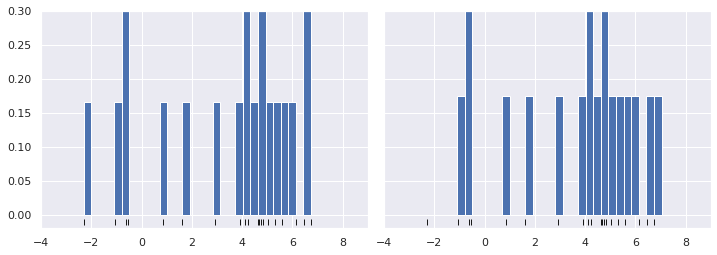

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density= True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

[左圖] 雙峰分布
[右圖] 單峰分布
若沒看前面的程式碼，可能會以為是來自不同的資料。

(-0.2, 8.0)

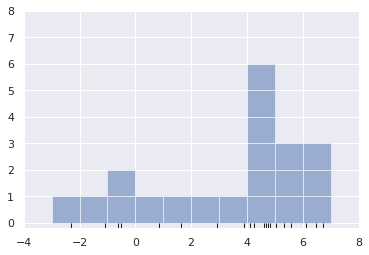

In [14]:
# 可把直方圖看成是區塊的堆疊
# 在每個籃子中在美個資料點上方堆一個區塊
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

2籃子間的區隔問題: 區塊堆疊的程度通常反映出不是此資料點附近實際的密度，而是此籃子在資料點中如何對齊的巧合。在資料點間出現沒有對齊的情況，就可能會出現不佳的直方圖，但若不讓這些區塊和籃子對齊，而依照資料點實際表現出的樣子堆疊這些區塊，雖然不會對齊，但可以增加他們在每一個位置上沿著x軸分布而形成結果。

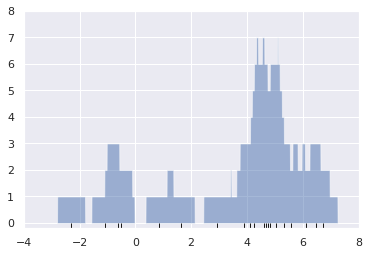

In [15]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

雖然結果有點雜亂，但可以比標準的直方圖更強固的反映出實際資料的特性。

用高斯平滑函數取代方塊，使邊緣比較有美感。

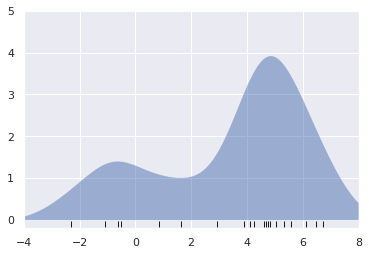

In [16]:
# 高斯平滑函數
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

此種利用在每一個輸入資料點上貢獻的高斯分布取得的平滑過的圖表，它給我們關於資料分布的形狀更多正確的概念，而且更少變異量(在不同的取樣中較不會反應出改變)。

前面兩張圖表是在一維中的核密度估計例子:第一個使用一個"tophat"核心，而第二個使用 Gaussian核心。

## 核密度估計實務

核密度估計一些可以使用的參數包括*核心*(kernel)，也就是用來指定每一個點所放置的分布形狀，以及*核心帶寬*(kernel bandwidth)，用來控制每一個點的核心大小。

以下為實作Scikit-Learn``KernelDensity``評估器:

(-0.02, 0.22)

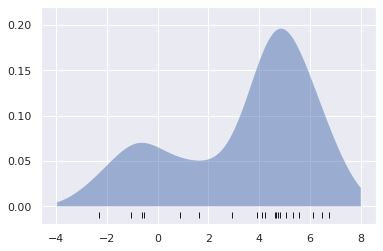

In [17]:
from sklearn.neighbors import KernelDensity

# 實體化和擬合KDE模型
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# 傳回機率密度的log
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

此處結果是經過正規化的，所以曲線下面積為1.

### 經由交叉驗證選用帶寬

在KDE中，帶寬的選擇在尋找一個合適的密度評估時很重要，而且它是一個可調整的旋鈕，可以在核密度估計中，控制誤差-變異(bias-variance)之間的取捨;太過窄化帶寬會造成一個高變異的估計(overfitting)，單一個點的有無就會造成很大的差異。太過寬的帶寬會導致高誤差估計(Underfitting)，在資料中的結果會被過寬的核心所淘汰。

在機器學習的領域中，在Scikit-Learn中的``KernelDensity``評估器被設計來讓它們可以被直接使用在Scikit-Learn中的grid search (``GridSearchCV``)去最佳化之前資料集的帶寬。因為資料集不大，所以用leave-one-out cross-validation。

In [21]:
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

In [22]:
# 找出最大化分數
grid.best_params_

{'bandwidth': 1.1233240329780276}

此最佳帶寬可以看到非常接近之前所繪出例子的值，也就是帶寬是1.0(也就是在``scipy.stats.norm``的預設帶寬)的情況。

## 舉例: 在球面上的KDE

In [23]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# 取得物種ID和位置的matrices/arrays
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

資料載入後, 可使用Basemap工具箱把此兩種生物被觀察到的，在南美地圖上畫出

In [25]:
!pip3 install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 863 kB 21.0 MB/s 
     |████████████████████████████████| 6.3 MB 53.5 MB/s 
     |████████████████████████████████| 219 kB 47.8 MB/s 
     |████████████████████████████████| 30.5 MB 1.8 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=e8e0dbc08b9b89327c888561f41d051730e8e3e85a7928f1be6e654192556b0d
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [28]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

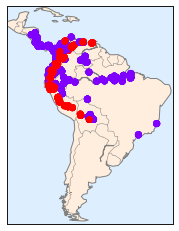

In [29]:
from mpl_toolkits.basemap import Basemap
#from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# 使用basemap繪出海岸線
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

這無法給我們對於這些生物密度有好的理解，因為這些生物的範圍可能會和其他重疊，所以可使用核密度估計去顯示出更能夠被理解的分布情況: 也就是在地圖上使用一個平滑的密度指標。因為此座標系統是放在一個球面而不是平面，將使用``haversine`` distance metric, 它可以校正在曲面上的距離表示。

以下是一個樣板程式碼(此為Basemap工具箱的其中一個缺點)，但每一程式碼區塊所代表的意義比較清楚:

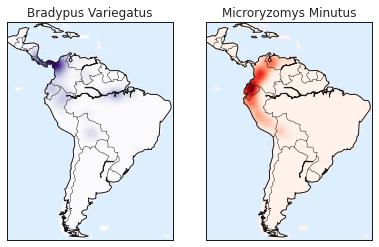

In [30]:
# 為此地形圖設置資料網格
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# 建立2個並排的圖表
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # 建立分布的spherical kernel density估計
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # 只在陸地上進行估算: -9999表示海洋
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # 繪出密度地形圖
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

和一開始繪製的簡單散點圖比較，此視覺化所畫出來的，更清楚的描繪出此二種生物被觀察到之地理分布情形